# Ансамбль


In [1]:
# Базовые импорты (без try/except, дисциплина превыше всего)
from __future__ import annotations
import inspect
import json
import math
import os
import re
import string
import tarfile
import unicodedata
from collections import Counter
from dataclasses import dataclass
from functools import lru_cache
import warnings
from io import StringIO
from pathlib import Path
from tempfile import NamedTemporaryFile
from typing import Callable, Dict, Iterable, List, Optional, Sequence, Tuple
# Backport inspect.getargspec removed in Python 3.11 for pymorphy2 compatibility
if not hasattr(inspect, "getargspec"):
    from collections import namedtuple
    ArgSpec = namedtuple("ArgSpec", ["args", "varargs", "keywords", "defaults"])
    def _getargspec(func):
        spec = inspect.getfullargspec(func)
        return ArgSpec(spec.args, spec.varargs, spec.varkw, spec.defaults)
    inspect.getargspec = _getargspec  # type: ignore[attr-defined]
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from lightgbm import LGBMClassifier
from pymorphy2 import MorphAnalyzer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, roc_curve,
                             precision_recall_curve, auc)
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.utils import check_random_state
from sklearn.exceptions import ConvergenceWarning
import fasttext
from gensim.models import Word2Vec
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from sklearn.base import BaseEstimator, TransformerMixin


In [2]:
# Глобальные настройки предупреждений
warnings.filterwarnings("ignore", message="pkg_resources is deprecated")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="No further splits with positive gain")


## Конфигурация и контрольные параметры

Задаём пути, доли сплитов и численные настройки.

In [3]:
debug_flag = os.environ.get("STYLE_PIPELINE_DEBUG", "0").lower() not in {"0", "false", "no"}
debug_sample_env = os.environ.get("STYLE_PIPELINE_DEBUG_SIZE", "")
try:
    debug_sample_size = int(debug_sample_env) if debug_sample_env else 600
except ValueError:
    debug_sample_size = 600

# Конфигурация сгруппирована по смыслу. Меняйте значения из подписанных блоков,
# остальное оставлено как «рабочие» дефолты.
config: Dict[str, object] = {
    # === Пути и артефакты ===
    # "DATA_DIR": Path("./data"),  # где лежат архивы и итоговый csv
    "DATA_DIR": Path("cache_boosted/autolabel/fasttext"),  # где лежат архивы и итоговый csv
    "CACHE_DIR": Path("./cache_boosted"),  # сохраняем модели/признаки сюда
    #cache_boosted/autolabel/fasttext/fasttext_pseudo_labels.csv
    # "DATASET_FILENAME": "taiga_style_dataset.csv",
    "DATASET_FILENAME": "fasttext_pseudo_labels.csv",    
    "FEATURE_UNION_PKL": Path("cache_boosted/feature_union.joblib"),
    "LOGREG_PKL": Path("cache_boosted/logreg_elasticnet.joblib"),
    "SGD_PKL": Path("cache_boosted/sgd_elasticnet.joblib"),
    "WORD2VEC_MODEL": Path("cache_boosted/word2vec.model"),
    "RESULTS_CSV": Path("cache_boosted/model_results.csv"),
    "FASTTEXT_BIN_PATH": Path("cache_boosted/fasttext_ensemble.bin"),
    "FASTTEXT_PARAMS": {
        "epoch": 30,
        "lr": 0.5,
        "wordNgrams": 2,
        "dim": 200,
        "loss": "softmax",
    },
    "FASTTEXT_WEIGHT_GRID": 11,
    "TEXTCNN_STATE_PATH": Path("cache_boosted/textcnn_state.pt"),
    "BILSTM_STATE_PATH": Path("cache_boosted/bilstm_state.pt"),
    "LABEL_INDEX_JSON": Path("cache_boosted/label_index.json"),
    "SEQUENCE_VOCAB_JSON": Path("cache_boosted/sequence_vocab.json"),
    "ENSEMBLE_ERRORS_CSV": Path("data/misclassified_ensemble.csv"),
    "PSEUDO_LABELS_PATH": Path("cache_boosted/autolabel/pseudo_labels.csv"),
    "PSEUDO_MIN_CONFIDENCE": 0.70,  # читаем только псевдометки ≥0.7

    # === Базовые параметры корпуса ===
    "TARGET_COLUMN": "label",
    "TEXT_COLUMN": "text",
    "TEST_SIZE": 0.2,  # 20% в тест (0.15–0.3, если нужно больше проверки)
    "VAL_SIZE": 0.2,  # доля от train на валидацию (0.1–0.2)
    "MIN_TEXT_LENGTH": 10,  # используется для отчётов
    "RANDOM_STATE": 2024,
    "N_JOBS": os.cpu_count() or 4,
    "REBUILD_DATASET": False,  # True только при пересборке корпуса
    "DATASET_BALANCE_PER_CLASS": 5000,  # при пересборке: сколько примерoв на стиль
    "SEGMENT_MAX_CHARS": 380,  # справочно: ограничения из подготовки корпуса
    "SEGMENT_MIN_CHARS": 60,
    "SEGMENT_MAX_PER_FILE": 6,

    # === Источники (оставлены только активные) ===
    "RAW_SOURCES": [
        {
            "name": "Interfax",
            "kind": "interfax",
            "archive": "Interfax.tar.gz",
            "metadata_member": "home/tsha/Interfax/newmetadata.csv",
            "text_base": "home/tsha/Interfax/texts",
            "label": 1,
            "max_files": 2000,  # ↑ если нужно больше официальных новостей
        },
        {
            "name": "Social",
            "kind": "social",
            "archive": "social.tar.gz",
            "text_members": [
                "home/tsha/social/texts/vktexts.txt",
                "home/tsha/social/texts/fbtexts.txt",
                "home/tsha/social/texts/LiveJournalPostsandcommentsGICR.txt",
                "home/tsha/social/texts/twtexts.txt",
            ],
            "label": 0,
            "max_records": 1500,  # ↑ чтобы добавить больше постов
        },
    ],

    # === TF-IDF и эмбеддинги (оставьте по умолчанию, меняйте при нужде) ===
    "MAX_FEATURES_WORD": 120000,  # уменьшить при нехватке памяти
    "MAX_FEATURES_CHAR": 60000,
    "WORD_NGRAM_RANGE": (1, 3),
    "CHAR_NGRAM_RANGE": (3, 5),
    "MIN_DF_WORD": 3,
    "MIN_DF_CHAR": 2,
    "TF_SUBLINEAR": True,
    "WORD2VEC_DIM": 200,
    "WORD2VEC_WINDOW": 5,
    "WORD2VEC_MIN_COUNT": 2,

    # === Поиск и обучение моделей ===
    "LOGREG_SEARCH_ITER": 10,
    "SGD_SEARCH_ITER": 10,
    "CV_FOLDS": 5,
    "MAX_ITER_LINEAR": 200,
    "ENSEMBLE_WEIGHT_GRID": 21,
    "TEXTCNN_KERNEL_SIZES": [2, 3, 4],
    "TEXTCNN_FILTERS": 256,
    "BILSTM_HIDDEN_SIZE": 192,
    "BILSTM_NUM_LAYERS": 2,
    "SEQUENCE_MAX_LEN": 256,
    "BATCH_SIZE": 64,
    "SEQUENCE_EPOCHS": 10,
    "LEARNING_RATE": 1e-3,
    "EMBEDDING_DROPOUT": 0.3,
    "GRAD_CLIP": 1.5,
    "LGBM_N_ESTIMATORS": 800,
    "LGBM_LEARNING_RATE": 0.05,
    "LGBM_SUBSAMPLE": 0.8,
    "LGBM_COLSAMPLE": 0.8,
    "LGBM_REG_ALPHA": 0.1,
    "LGBM_REG_LAMBDA": 0.3,
    "EXTRATREES_N_ESTIMATORS": 600,
    "EXTRATREES_MIN_SAMPLES_SPLIT": 5,
    "EXTRATREES_MIN_SAMPLES_LEAF": 2,

    # === Отладка ===
    "DEBUG_MODE": debug_flag,
    "DEBUG_SAMPLE_SIZE": debug_sample_size,
}
if config["DEBUG_SAMPLE_SIZE"] <= 0:
    config["DEBUG_SAMPLE_SIZE"] = 600
if config["DEBUG_MODE"]:
    config["LOGREG_SEARCH_ITER"] = min(5, config["LOGREG_SEARCH_ITER"])
    config["SGD_SEARCH_ITER"] = min(5, config["SGD_SEARCH_ITER"])
    config["CV_FOLDS"] = min(3, config["CV_FOLDS"])
    config["MAX_ITER_LINEAR"] = min(100, config["MAX_ITER_LINEAR"])
    config["MAX_FEATURES_WORD"] = min(30000, config["MAX_FEATURES_WORD"])
    config["MAX_FEATURES_CHAR"] = min(15000, config["MAX_FEATURES_CHAR"])
    config["WORD2VEC_MIN_COUNT"] = 1
    config["WORD2VEC_WINDOW"] = min(3, config["WORD2VEC_WINDOW"])
    config["SEQUENCE_MAX_LEN"] = min(128, config["SEQUENCE_MAX_LEN"])
    config["BATCH_SIZE"] = min(64, config["BATCH_SIZE"])
    config["SEQUENCE_EPOCHS"] = min(3, config["SEQUENCE_EPOCHS"])
    config["ENSEMBLE_WEIGHT_GRID"] = min(11, config["ENSEMBLE_WEIGHT_GRID"])
    config["LGBM_N_ESTIMATORS"] = min(200, config["LGBM_N_ESTIMATORS"])
    config["EXTRATREES_N_ESTIMATORS"] = min(200, config["EXTRATREES_N_ESTIMATORS"])
    config["TEXTCNN_FILTERS"] = min(128, config["TEXTCNN_FILTERS"])
    config["BILSTM_HIDDEN_SIZE"] = min(128, config["BILSTM_HIDDEN_SIZE"])
    config["N_JOBS"] = 1
    config["DATASET_BALANCE_PER_CLASS"] = min(600, config["DATASET_BALANCE_PER_CLASS"])
    for source in config["RAW_SOURCES"]:
        if "max_files" in source:
            source["max_files"] = min(source["max_files"], config["DEBUG_SAMPLE_SIZE"])
        if "max_records" in source:
            source["max_records"] = min(source["max_records"], config["DEBUG_SAMPLE_SIZE"] * 2)
config["DATA_DIR"].mkdir(parents=True, exist_ok=True)
config["CACHE_DIR"].mkdir(parents=True, exist_ok=True)
# Путь до csv с готовым корпусом
config["DATASET_CSV"] = config["DATA_DIR"] / config["DATASET_FILENAME"]
for source in config["RAW_SOURCES"]:
    archive_path = Path(source["archive"])
    if not archive_path.is_absolute():
        archive_path = config["DATA_DIR"] / archive_path
    source["archive_path"] = archive_path
# Генератор случайных чисел для воспроизводимости
random_state = check_random_state(config["RANDOM_STATE"])



## Загрузка готового корпуса

Датасет формируется в ноутбуке `style_dataset_preparation.ipynb`. Здесь загружаем готовый CSV и фиксируем базовую статистику.


In [4]:
dataset_path = config["DATASET_CSV"]
if not dataset_path.exists():
    raise FileNotFoundError(
        f"Подготовленный датасет не найден: {dataset_path}. Выполните notebook style_dataset_preparation.ipynb."
    )
clean_df = pd.read_csv(dataset_path, encoding="utf-8")
text_column = config["TEXT_COLUMN"]
target_column = config["TARGET_COLUMN"]
raw_rows = int(len(clean_df))
fallback_source: Optional[str] = None
pseudo_applied = 0

if target_column not in clean_df.columns:
    pseudo_path_cfg = config.get("PSEUDO_LABELS_PATH")
    pseudo_min_conf = float(config.get("PSEUDO_MIN_CONFIDENCE", 0.0) or 0.0)
    pseudo_path = None
    if pseudo_path_cfg:
        pseudo_path = Path(pseudo_path_cfg)
        if not pseudo_path.is_absolute():
            pseudo_path = (Path.cwd() / pseudo_path).resolve()
        if not pseudo_path.exists():
            print(f"[WARN] Псевдометки не найдены по пути {pseudo_path}.")
            pseudo_path = None
    if pseudo_path is not None:
        pseudo_df = pd.read_csv(pseudo_path, encoding="utf-8")
        join_keys = [
            key for key in ("source_archive", "source_file") if key in clean_df.columns and key in pseudo_df.columns
        ]
        if not join_keys and "text" in pseudo_df.columns:
            join_keys = ["text"]
        if join_keys and "pseudo_label" in pseudo_df.columns:
            columns_to_keep = join_keys + ["pseudo_label"]
            if "pseudo_confidence" in pseudo_df.columns:
                columns_to_keep.append("pseudo_confidence")
            pseudo_filtered = pseudo_df[columns_to_keep].dropna(subset=["pseudo_label"]).copy()
            if pseudo_min_conf > 0 and "pseudo_confidence" in pseudo_filtered.columns:
                pseudo_filtered = pseudo_filtered[pseudo_filtered["pseudo_confidence"] >= pseudo_min_conf]
            pseudo_filtered = pseudo_filtered.drop_duplicates(subset=join_keys, keep="first")
            if not pseudo_filtered.empty:
                clean_df = clean_df.merge(pseudo_filtered, on=join_keys, how="left")
                mask = clean_df["pseudo_label"].notna()
                if mask.any():
                    clean_df.loc[mask, target_column] = clean_df.loc[mask, "pseudo_label"].astype(int)
                    fallback_source = "pseudo_labels"
                    pseudo_applied = int(mask.sum())
                    if "pseudo_confidence" in clean_df.columns:
                        clean_df.rename(
                            columns={"pseudo_confidence": "pseudo_label_confidence"}, inplace=True
                        )
                    print(
                        f"[INFO] Используем pseudo_labels: {pseudo_applied} строк (min_conf={pseudo_min_conf:.2f})."
                    )
                clean_df.drop(columns=["pseudo_label"], inplace=True, errors="ignore")
    if fallback_source is None:
        style_labels = {int(k): v for k, v in config.get("STYLE_LABELS", {}).items()}
        if "style_hint_label" in clean_df.columns:
            fallback_source = "style_hint_label"

            def _from_hint_label(value):
                if pd.isna(value):
                    return None
                try:
                    idx = int(value)
                except (TypeError, ValueError):  # noqa: PERF203
                    return None
                if idx < 0:
                    return None
                return style_labels.get(idx, str(idx))

            clean_df[target_column] = clean_df["style_hint_label"].apply(_from_hint_label)
        elif "style_hint" in clean_df.columns:
            fallback_source = "style_hint"
            clean_df[target_column] = clean_df["style_hint"].astype(str).str.strip()
            clean_df[target_column].replace({"": None}, inplace=True)
        else:
            available = ", ".join(clean_df.columns)
            raise KeyError(
                f"В датасете нет столбца '{target_column}' и не найдено столбцов style_hint*. Доступные колонки: {available}"
            )
        print(
            f"[WARN] Колонка '{target_column}' отсутствовала в CSV. Используем '{fallback_source}' как псевдометки."
        )

clean_df = clean_df.dropna(subset=[text_column, target_column]).copy()
clean_df[text_column] = clean_df[text_column].astype(str)
clean_df[target_column] = clean_df[target_column].astype(str)
clean_df = clean_df[clean_df[target_column].str.len() > 0].reset_index(drop=True)

corpus_stats: Dict[str, object] = {
    "raw_rows": raw_rows,
    "usable_rows": int(len(clean_df)),
    "target_source": fallback_source or "dataset",
    "pseudo_applied": pseudo_applied,
}



[INFO] Используем pseudo_labels: 15000 строк (min_conf=0.70).


## Стратифицированные сплиты

Корпус разбивается на обучающую, валидационную и тестовую выборки посредством `StratifiedShuffleSplit` с параметрами из конфигурации. Для каждой записи создаётся числовой идентификатор метки (`label_id`), формируются словари `label_to_index` и `index_to_label`, которые сериализуются в `cache_boosted/label_index.json`. Размеры выборок и распределение классов фиксируются в `corpus_stats`.


In [5]:
text_column = config["TEXT_COLUMN"]
target_column = config["TARGET_COLUMN"]

clean_df[target_column] = clean_df[target_column].astype(str)

sss_test = StratifiedShuffleSplit(
    n_splits=1,
    test_size=config["TEST_SIZE"],
    random_state=config["RANDOM_STATE"],
)
train_val_idx, test_idx = next(sss_test.split(clean_df[text_column], clean_df[target_column]))
train_val_df = clean_df.iloc[train_val_idx].reset_index(drop=True)
test_df = clean_df.iloc[test_idx].reset_index(drop=True)

val_relative = config["VAL_SIZE"] / (1 - config["TEST_SIZE"])
sss_val = StratifiedShuffleSplit(
    n_splits=1,
    test_size=val_relative,
    random_state=config["RANDOM_STATE"],
)
train_idx, val_idx = next(sss_val.split(train_val_df[text_column], train_val_df[target_column]))
train_df = train_val_df.iloc[train_idx].reset_index(drop=True)
val_df = train_val_df.iloc[val_idx].reset_index(drop=True)

for frame in (train_df, val_df, test_df):
    frame[target_column] = frame[target_column].astype(str)

split_sizes = {
    "train": len(train_df),
    "val": len(val_df),
    "test": len(test_df),
}
corpus_stats["split_sizes"] = split_sizes

class_distribution = {
    "train": train_df[target_column].value_counts(normalize=True).sort_index().to_dict(),
    "val": val_df[target_column].value_counts(normalize=True).sort_index().to_dict(),
    "test": test_df[target_column].value_counts(normalize=True).sort_index().to_dict(),
}
corpus_stats["class_distribution"] = class_distribution

unique_labels = sorted(str(label) for label in train_df[target_column].unique())
label_to_index: Dict[str, int] = {label: int(idx) for idx, label in enumerate(unique_labels)}
index_to_label: Dict[int, str] = {int(idx): label for label, idx in label_to_index.items()}
label_id_column = f"{target_column}_id"
splits = {"train": train_df, "val": val_df, "test": test_df}
for split_name, frame in splits.items():
    encoded = frame[target_column].map(label_to_index)
    if encoded.isnull().any():
        missing = frame.loc[encoded.isnull(), target_column].unique()
        raise ValueError(f"В выборке {split_name} встретились неизвестные метки: {missing}")
    frame[label_id_column] = encoded.astype(int)

num_classes = len(label_to_index)
class_names = np.array([index_to_label[idx] for idx in range(num_classes)])
corpus_stats["num_classes"] = num_classes
corpus_stats["classes"] = class_names.tolist()

corpus_stats


label_index_path = Path(config["LABEL_INDEX_JSON"])
label_index_path.parent.mkdir(parents=True, exist_ok=True)
label_to_index_serializable = {str(k): int(v) for k, v in label_to_index.items()}
index_to_label_serializable = {str(int(k)): str(v) for k, v in index_to_label.items()}
with open(label_index_path, "w", encoding="utf-8") as fp:
    json.dump({
        "label_to_index": label_to_index_serializable,
        "index_to_label": index_to_label_serializable,
    }, fp, ensure_ascii=False, indent=2)



## Нормализация текста и подготовка признаков

Определяются функции текстовой нормализации и вспомогательные трансформеры. Тексты приводятся к нижнему регистру, очищаются от URL и упоминаний, лемматизируются (`pymorphy2`). Для каждого сплита формируется столбец `normalized_text`, а `NumericFeaturesTransformer` обеспечивает вычисление числовых характеристик (длина, количество слов, эмодзи, хэштеги, доля заглавных символов).


In [6]:
URL_PATTERN = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE | re.VERBOSE)
MENTION_PATTERN = re.compile(r"@[\w_]+")
HASHTAG_PATTERN = re.compile(r"#[\w_]+")
EMOJI_PATTERN = re.compile(r"[🌀-🗿😀-🙏🚀-🛿🜀-🝿]")
PUNCT_TABLE = str.maketrans({ch: " " for ch in string.punctuation if ch not in "#@"})
morph = MorphAnalyzer()

STOP_CHARS = re.compile(r"[^а-яёa-z0-9#@\s]")


@lru_cache(maxsize=200000)
def lemmatize_token(token: str) -> str:
    """Return lemma for token using pymorphy2 (memoized)."""
    return morph.parse(token)[0].normal_form


def normalize_text(text: str) -> str:
    """Prepare text for word-level features: lowercase, clean, lemmatize."""
    clean = text.lower()
    clean = URL_PATTERN.sub(" ", clean)
    clean = MENTION_PATTERN.sub(" ", clean)
    clean = clean.translate(PUNCT_TABLE)
    clean = STOP_CHARS.sub(" ", clean)
    tokens = [token for token in clean.split() if token]
    lemmas: List[str] = []
    for token in tokens:
        if token.startswith("#"):
            lemmas.append(token)
            continue
        lemmas.append(lemmatize_token(token))
    return " ".join(lemmas)


def count_emoji(text: str) -> int:
    """Count unicode emoji in the raw text."""
    return len(EMOJI_PATTERN.findall(text))


class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select a single column from DataFrame within sklearn pipeline."""
    def __init__(self, column: str) -> None:
        self.column = column

    def fit(self, X, y=None):  # type: ignore[override]
        return self

    def transform(self, X):  # type: ignore[override]
        return X[self.column]


class ColumnsSelector(BaseEstimator, TransformerMixin):
    """Select a set of columns from DataFrame."""
    def __init__(self, columns: Sequence[str]) -> None:
        self.columns = list(columns)

    def fit(self, X, y=None):  # type: ignore[override]
        return self

    def transform(self, X):  # type: ignore[override]
        return X[self.columns]


def compute_numeric_features(frame: pd.DataFrame) -> np.ndarray:
    """Compute length-based and stylistic numeric features for each record."""
    texts = frame[text_column].values
    normalized = frame["normalized_text"].values

    lengths = np.array([len(t) for t in texts])[:, None]
    word_counts = np.array([len(t.split()) for t in normalized])[:, None]
    emoji_counts = np.array([count_emoji(t) for t in texts])[:, None]
    hashtag_counts = np.array([t.count("#") for t in texts])[:, None]
    upper_ratio = np.array([
        sum(1 for ch in t if ch.isupper()) / max(1, len(t)) for t in texts
    ])[:, None]
    digit_ratio = np.array([
        sum(ch.isdigit() for ch in t) / max(1, len(t)) for t in texts
    ])[:, None]
    quote_ratio = np.array([
        t.count('"') / max(1, len(t)) for t in texts
    ])[:, None]
    sentence_marks = np.array([
        sum(t.count(mark) for mark in ".!?") for t in texts
    ])[:, None]

    return np.hstack([
        lengths,
        word_counts,
        emoji_counts,
        hashtag_counts,
        upper_ratio,
        digit_ratio,
        quote_ratio,
        sentence_marks,
    ])


for frame in (train_df, val_df, test_df):
    frame["normalized_text"] = frame[text_column].apply(normalize_text)


class NumericFeaturesTransformer(BaseEstimator, TransformerMixin):
    """Sklearn-compatible wrapper transforming DataFrame into numeric features."""
    def fit(self, X, y=None):  # type: ignore[override]
        return self

    def transform(self, X):  # type: ignore[override]
        return compute_numeric_features(X)



## Конструктор комбинированных признаков

Строится конвейер `FeatureUnion`, объединяющий word TF-IDF, char TF-IDF и числовые признаки. Конвейер обучается на `train_df`, применяются трансформации к `val_df` и `test_df`. Полученные матрицы (`X_train`, `X_val`, `X_test`) используются последующими моделями; сериализованный конвейер сохраняется в `cache_boosted/feature_union.joblib`.


In [7]:
memory = joblib.Memory(location=config["CACHE_DIR"], verbose=0)

word_vectorizer = TfidfVectorizer(
    ngram_range=config["WORD_NGRAM_RANGE"],
    min_df=config["MIN_DF_WORD"],
    max_features=config["MAX_FEATURES_WORD"],
    sublinear_tf=config["TF_SUBLINEAR"],
    analyzer="word",
    lowercase=False,
)

char_vectorizer = TfidfVectorizer(
    ngram_range=config["CHAR_NGRAM_RANGE"],
    min_df=config["MIN_DF_CHAR"],
    max_features=config["MAX_FEATURES_CHAR"],
    analyzer="char",
    lowercase=False,
)

numeric_pipeline = Pipeline(
    steps=[
        ("selector", ColumnsSelector([text_column, "normalized_text"])),
        ("numeric", NumericFeaturesTransformer()),
        ("scaler", MaxAbsScaler()),
    ]
)

feature_union = FeatureUnion(
    transformer_list=[
        (
            "word",
            Pipeline(
                [
                    ("selector", ColumnSelector("normalized_text")),
                    ("tfidf", word_vectorizer),
                ]
            ),
        ),
        (
            "char",
            Pipeline(
                [
                    ("selector", ColumnSelector(text_column)),
                    ("tfidf", char_vectorizer),
                ]
            ),
        ),
        ("numeric", numeric_pipeline),
    ],
    n_jobs=config["N_JOBS"],
    transformer_weights={"word": 0.6, "char": 0.35, "numeric": 0.05},
)

X_train = feature_union.fit_transform(train_df)
X_val = feature_union.transform(val_df)
X_test = feature_union.transform(test_df)

joblib.dump(feature_union, config["FEATURE_UNION_PKL"])

y_train = train_df[label_id_column].to_numpy()
y_val = val_df[label_id_column].to_numpy()
y_test = test_df[label_id_column].to_numpy()

feature_union




/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

,transformer_list,"[('word', ...), ('char', ...), ...]"
,n_jobs,12
,transformer_weights,"{'char': 0.35, 'numeric': 0.05, 'word': 0.6}"
,verbose,False
,verbose_feature_names_out,True
,column,'normalized_text'
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,False


## Сводка результатов моделей

Складываем метрики в общий список и затем собираем DataFrame.

In [8]:

model_results: List[Dict[str, object]] = []
model_registry: Dict[str, object] = {}
prediction_store: Dict[str, Dict[str, np.ndarray]] = {}


## Логистическая регрессия с elasticnet и RandomizedSearchCV

Обучается линейный классификатор на TF-IDF признаках. Случайный поиск по `C` и `l1_ratio` выполняется с метрикой `macro F1`. Лучшая модель сохраняется в `cache_boosted/logreg_elasticnet.joblib`, а прогнозы и метрики добавляются в `prediction_store` и `model_results`.


In [9]:

logreg = LogisticRegression(
    solver="saga",               # поддерживает elasticnet
    penalty="elasticnet",
    max_iter=config["MAX_ITER_LINEAR"],
    class_weight="balanced",      # компенсируем потенциальный дисбаланс
    n_jobs=config["N_JOBS"],
)

logreg_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions={
        "C": np.logspace(-2, 1, 50),
        "l1_ratio": np.linspace(0.0, 1.0, 21),
    },
    n_iter=config["LOGREG_SEARCH_ITER"],
    scoring="f1_macro",
    cv=config["CV_FOLDS"],
    random_state=config["RANDOM_STATE"],
    n_jobs=config["N_JOBS"],
    verbose=1,
)

# Проводим случайный поиск по регуляризации и сразу обучаем модель
logreg_search.fit(X_train, y_train)
logreg_best = logreg_search.best_estimator_

# Получаем прогнозы и метрики
val_pred = logreg_best.predict(X_val)
val_prob = logreg_best.predict_proba(X_val)
test_pred = logreg_best.predict(X_test)
test_prob = logreg_best.predict_proba(X_test)

logreg_metrics = {
    "model": "logreg_elasticnet",
    "val_accuracy": accuracy_score(y_val, val_pred),
    "val_f1_macro": f1_score(y_val, val_pred, average="macro"),
    "test_accuracy": accuracy_score(y_test, test_pred),
    "test_f1_macro": f1_score(y_test, test_pred, average="macro"),
}

model_results.append(logreg_metrics)
model_registry["logreg_elasticnet"] = logreg_best
prediction_store["logreg_elasticnet"] = {
    "val_prob": val_prob,
    "test_prob": test_prob,
}

joblib.dump(logreg_best, config["LOGREG_PKL"])  # сохраняем для повторного использования


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


['cache_boosted/logreg_elasticnet.joblib']

## SGDClassifier с ранней остановкой

Обучается стохастический линейный классификатор с логистической функцией потерь и ранней остановкой. Подбор параметров (`alpha`, `l1_ratio`, `eta0`) производится через `RandomizedSearchCV`. Результаты сохраняются аналогично логистической регрессии.


In [10]:

sgd = SGDClassifier(
    loss="log_loss",
    penalty="elasticnet",
    early_stopping=True,
    n_iter_no_change=5,
    max_iter=1000,
    tol=1e-4,
    random_state=config["RANDOM_STATE"],
    class_weight="balanced",
)

sgd_search = RandomizedSearchCV(
    estimator=sgd,
    param_distributions={
        "alpha": np.logspace(-6, -3, 50),
        "l1_ratio": np.linspace(0.05, 0.95, 19),
        "eta0": np.logspace(-3, -1, 30),
    },
    n_iter=config["SGD_SEARCH_ITER"],
    scoring="f1_macro",
    cv=config["CV_FOLDS"],
    random_state=config["RANDOM_STATE"],
    n_jobs=config["N_JOBS"],
    verbose=1,
)

# Обучаем стохастическую модель и оцениваем качество
sgd_search.fit(X_train, y_train)
sgd_best = sgd_search.best_estimator_

val_pred = sgd_best.predict(X_val)
val_prob = sgd_best.predict_proba(X_val)
test_pred = sgd_best.predict(X_test)
test_prob = sgd_best.predict_proba(X_test)

sgd_metrics = {
    "model": "sgd_elasticnet",
    "val_accuracy": accuracy_score(y_val, val_pred),
    "val_f1_macro": f1_score(y_val, val_pred, average="macro"),
    "test_accuracy": accuracy_score(y_test, test_pred),
    "test_f1_macro": f1_score(y_test, test_pred, average="macro"),
}

model_results.append(sgd_metrics)
model_registry["sgd_elasticnet"] = sgd_best
prediction_store["sgd_elasticnet"] = {
    "val_prob": val_prob,
    "test_prob": test_prob,
}

joblib.dump(sgd_best, config["SGD_PKL"])  # сохраняем лучшую модель


Fitting 5 folds for each of 10 candidates, totalling 50 fits


['cache_boosted/sgd_elasticnet.joblib']

## fastText baseline и подключение к ансамблю
Обучаем fastText на тех же сплитах, что и линейные/нейросетевые модели, сохраняем метрики и вероятности.


In [11]:
# Обучаем fastText на тех же train/val/test
def format_ft_label(idx: int) -> str:
    return f"__label__{idx}"

def export_fasttext_split(frame, prefix: str) -> Path:
    tmp = NamedTemporaryFile("w", encoding="utf-8", delete=False, suffix=f"_{prefix}.txt")
    for text, label in zip(frame[text_column], frame[label_id_column]):
        normalized = " ".join(str(text).split())
        tmp.write(f"{format_ft_label(int(label))} {normalized}\n")
    tmp_path = Path(tmp.name)
    tmp.close()
    return tmp_path

train_tmp = export_fasttext_split(train_df, "train")
val_tmp = export_fasttext_split(val_df, "val")
test_tmp = export_fasttext_split(test_df, "test")

fasttext_params = dict(config.get("FASTTEXT_PARAMS", {}))
fasttext_params.setdefault("verbose", 2)
fasttext_model = fasttext.train_supervised(input=train_tmp.as_posix(), **fasttext_params)

def ft_predict(texts):
    labels, probs = fasttext_model.predict(texts)
    label_ids = [int(label[0].replace('__label__', '')) for label in labels]
    confidences = [p[0] for p in probs]
    return np.array(label_ids), np.array(confidences), np.array([p for p in probs])

val_ids, val_conf, val_prob_ft = ft_predict(val_df[text_column].tolist())
test_ids, test_conf, test_prob_ft = ft_predict(test_df[text_column].tolist())
train_ids, train_conf, train_prob_ft = ft_predict(train_df[text_column].tolist())

fasttext_metrics = {
    "model": "fasttext",
    "val_accuracy": accuracy_score(val_df[label_id_column], val_ids),
    "val_f1_macro": f1_score(val_df[label_id_column], val_ids, average='macro'),
    "test_accuracy": accuracy_score(test_df[label_id_column], test_ids),
    "test_f1_macro": f1_score(test_df[label_id_column], test_ids, average='macro'),
}
model_results.append(fasttext_metrics)
model_registry['fasttext'] = fasttext_model
prediction_store['fasttext'] = {
    'val_prob': val_prob_ft,
    'test_prob': test_prob_ft,
    'train_prob': train_prob_ft,
}
fasttext_model.save_model(config['FASTTEXT_BIN_PATH'].as_posix())
for tmp in (train_tmp, val_tmp, test_tmp):
    if tmp.exists():
        tmp.unlink(missing_ok=True)
fasttext_metrics


Read 0M words
Number of words:  76202
Number of labels: 2
Progress: 100.0% words/sec/thread:  923389 lr:  0.000000 avg.loss:  0.016336 ETA:   0h 0m 0s


{'model': 'fasttext',
 'val_accuracy': 0.9353333333333333,
 'val_f1_macro': 0.6128661474727211,
 'test_accuracy': 0.9333333333333333,
 'test_f1_macro': 0.5919655292479109}

## Плотные эмбеддинги и градиентный бустинг
Строятся word2vec-эмбеддинги корпуса (skip-gram), после чего обучаются `LGBMClassifier` и `ExtraTreesClassifier` на усреднённых векторах документов. Модели и их метрики добавляются в общую таблицу, векторы слов сохраняются в `cache_boosted/word2vec.model`.


In [12]:
def tokenize_for_embeddings(text: str) -> List[str]:
    """Tokenize text into alphanumeric tokens for Word2Vec training."""
    return [tok for tok in re.findall(r"[a-zA-Zа-яА-ЯёЁ0-9#@]+", text.lower()) if tok]
def build_word2vec(corpus: Sequence[str]) -> Word2Vec:
    """Train skip-gram Word2Vec model on provided corpus."""
    sentences = [tokenize_for_embeddings(doc) for doc in corpus]
    model = Word2Vec(
        sentences=sentences,
        vector_size=config["WORD2VEC_DIM"],
        window=config["WORD2VEC_WINDOW"],
        min_count=config["WORD2VEC_MIN_COUNT"],
        sg=1,
        workers=config["N_JOBS"],
        seed=config["RANDOM_STATE"],
    )
    return model
def vectorize_with_embeddings(model: Word2Vec, corpus: Sequence[str]) -> np.ndarray:
    """Average word embeddings per document (fallback to zeros for empty docs)."""
    embeddings = []
    for doc in corpus:
        tokens = tokenize_for_embeddings(doc)
        if not tokens:
            embeddings.append(np.zeros(model.vector_size, dtype=np.float32))
            continue
        vectors = [model.wv[token] for token in tokens if token in model.wv]
        if not vectors:
            embeddings.append(np.zeros(model.vector_size, dtype=np.float32))
        else:
            embeddings.append(np.mean(vectors, axis=0))
    return np.vstack(embeddings)
w2v_model = build_word2vec(train_df[text_column])
train_emb = vectorize_with_embeddings(w2v_model, train_df[text_column])
val_emb = vectorize_with_embeddings(w2v_model, val_df[text_column])
test_emb = vectorize_with_embeddings(w2v_model, test_df[text_column])
train_emb_df = pd.DataFrame(train_emb, columns=[f"emb_{i}" for i in range(train_emb.shape[1])])
val_emb_df = pd.DataFrame(val_emb, columns=[f"emb_{i}" for i in range(val_emb.shape[1])])
test_emb_df = pd.DataFrame(test_emb, columns=[f"emb_{i}" for i in range(test_emb.shape[1])])
lgbm_params = {
    "n_estimators": config["LGBM_N_ESTIMATORS"],
    "learning_rate": config["LGBM_LEARNING_RATE"],
    "max_depth": -1,
    "subsample": config["LGBM_SUBSAMPLE"],
    "colsample_bytree": config["LGBM_COLSAMPLE"],
    "reg_alpha": config["LGBM_REG_ALPHA"],
    "reg_lambda": config["LGBM_REG_LAMBDA"],
    "random_state": config["RANDOM_STATE"],
    "n_jobs": config["N_JOBS"],
}
lgbm = LGBMClassifier(**lgbm_params)
lgbm.fit(train_emb_df, y_train, eval_set=[(val_emb_df, y_val)], eval_metric="multi_logloss")
val_pred = lgbm.predict(val_emb_df)
val_prob = lgbm.predict_proba(val_emb_df)
test_pred = lgbm.predict(test_emb_df)
test_prob = lgbm.predict_proba(test_emb_df)
lgbm_metrics = {
    "model": "lgbm_w2v",
    "val_accuracy": accuracy_score(y_val, val_pred),
    "val_f1_macro": f1_score(y_val, val_pred, average="macro"),
    "test_accuracy": accuracy_score(y_test, test_pred),
    "test_f1_macro": f1_score(y_test, test_pred, average="macro"),
}
model_results.append(lgbm_metrics)
model_registry["lgbm_w2v"] = lgbm
prediction_store["lgbm_w2v"] = {
    "val_prob": val_prob,
    "test_prob": test_prob,
}
extra_params = {
    "n_estimators": config["EXTRATREES_N_ESTIMATORS"],
    "max_depth": None,
    "min_samples_split": config["EXTRATREES_MIN_SAMPLES_SPLIT"],
    "min_samples_leaf": config["EXTRATREES_MIN_SAMPLES_LEAF"],
    "random_state": config["RANDOM_STATE"],
    "n_jobs": config["N_JOBS"],
}
extra = ExtraTreesClassifier(**extra_params)
extra.fit(train_emb_df, y_train)
val_pred_extra = extra.predict(val_emb_df)
val_prob_extra = extra.predict_proba(val_emb_df)
test_pred_extra = extra.predict(test_emb_df)
test_prob_extra = extra.predict_proba(test_emb_df)
extra_metrics = {
    "model": "extratrees_w2v",
    "val_accuracy": accuracy_score(y_val, val_pred_extra),
    "val_f1_macro": f1_score(y_val, val_pred_extra, average="macro"),
    "test_accuracy": accuracy_score(y_test, test_pred_extra),
    "test_f1_macro": f1_score(y_test, test_pred_extra, average="macro"),
}
model_results.append(extra_metrics)
model_registry["extratrees_w2v"] = extra
prediction_store["extratrees_w2v"] = {
    "val_prob": val_prob_extra,
    "test_prob": test_prob_extra,
}
w2v_model.save(str(config["WORD2VEC_MODEL"]))
extra_metrics


[LightGBM] [Info] Number of positive: 650, number of negative: 8350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072222 -> initscore=-2.553044
[LightGBM] [Info] Start training from score -2.553044


{'model': 'extratrees_w2v',
 'val_accuracy': 0.9316666666666666,
 'val_f1_macro': 0.5385096789152951,
 'test_accuracy': 0.9306666666666666,
 'test_f1_macro': 0.5336936247548902}

## Подготовка данных для последовательных моделей

Формируется словарь токенов (`vocab`) с ограничением по размеру и частоте, реализуются классы `TextDataset` и `DataLoader` для подачи данных в PyTorch, словарь сериализуется в `cache_boosted/sequence_vocab.json`.


In [13]:

def tokenize_for_sequence(text: str) -> List[str]:
    """Tokenize text for sequence models (alphanumeric + hashtags)."""
    return [tok for tok in re.findall(r"[a-zA-Zа-яА-ЯёЁ0-9#@]+", text.lower()) if tok]


def build_vocabulary(corpus: Sequence[str], max_size: int = 50000, min_freq: int = 2) -> Dict[str, int]:
    """Construct vocabulary mapping token to index with limits on size and frequency."""
    counter: Counter[str] = Counter()
    for doc in corpus:
        counter.update(tokenize_for_sequence(doc))
    most_common = [token for token, freq in counter.items() if freq >= min_freq]
    most_common = sorted(most_common, key=lambda tok: (-counter[tok], tok))[:max_size]
    vocab = {"<pad>": 0, "<unk>": 1}
    for idx, token in enumerate(most_common, start=2):
        vocab[token] = idx
    return vocab


def encode_document(text: str, vocab: Dict[str, int], max_len: int) -> List[int]:
    """Encode text into fixed-length sequence of token indices with padding."""
    tokens = tokenize_for_sequence(text)
    indices = [vocab.get(tok, 1) for tok in tokens]
    if len(indices) >= max_len:
        return indices[:max_len]
    padded = indices + [0] * (max_len - len(indices))
    return padded


vocab = build_vocabulary(train_df[text_column], max_size=80000, min_freq=2)
num_classes = len(label_to_index)


class TextDataset(Dataset):
    """Dataset wrapper returning encoded text tensor and corresponding label tensor."""
    def __init__(self, texts: Sequence[str], labels: Sequence[int], vocab: Dict[str, int], max_len: int) -> None:
        self.texts = list(texts)
        self.labels = list(labels)
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        encoded = encode_document(self.texts[idx], self.vocab, self.max_len)
        label = int(self.labels[idx])
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long)


def create_dataloader(texts: Sequence[str], labels: Sequence[int], *, shuffle: bool) -> DataLoader:
    """Instantiate DataLoader with shared parameters for sequence models."""
    dataset = TextDataset(texts, labels, vocab=vocab, max_len=config["SEQUENCE_MAX_LEN"])
    return DataLoader(dataset, batch_size=config["BATCH_SIZE"], shuffle=shuffle)


train_loader = create_dataloader(train_df[text_column], train_df[label_id_column], shuffle=True)
val_loader = create_dataloader(val_df[text_column], val_df[label_id_column], shuffle=False)
test_loader = create_dataloader(test_df[text_column], test_df[label_id_column], shuffle=False)

with open(config["SEQUENCE_VOCAB_JSON"], "w", encoding="utf-8") as fp:
    json.dump({str(k): int(v) for k, v in vocab.items()}, fp, ensure_ascii=False)



## Базовые классы TextCNN и BiLSTM

Содержит реализации последовательных моделей (`TextCNN`, `BiLSTMAttention`) и вспомогательных процедур (`train_sequence_model`, `evaluate_sequence_model`, `predict_sequence_model`).

In [23]:

@dataclass
class TrainState:
    """Training state snapshot used to retain best checkpoint."""
    history: List[Dict[str, float]]
    best_val_score: float
    best_epoch: int
    best_state_dict: Dict[str, torch.Tensor]


def build_embedding_matrix(vocab: Dict[str, int], vector_size: int) -> torch.Tensor:
    """Initialize embedding matrix with uniform distribution and zero padding vector."""
    scale = 0.05
    embedding = torch.empty(len(vocab), vector_size).uniform_(-scale, scale)
    embedding[0].zero_()
    return embedding


class TextCNN(nn.Module):
    """Convolutional neural network for sentence classification."""
    def __init__(self, vocab_size: int, embed_dim: int, num_classes: int, kernel_sizes: Sequence[int], num_filters: int) -> None:
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList(
            [nn.Conv1d(embed_dim, num_filters, kernel_size, padding=kernel_size // 2) for kernel_size in kernel_sizes]
        )
        self.dropout = nn.Dropout(config["EMBEDDING_DROPOUT"])
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        embedded = self.embedding(input_ids)
        x = embedded.transpose(1, 2)
        pooled = []
        for conv in self.convs:
            activated = F.relu(conv(x))
            pooled.append(F.max_pool1d(activated, kernel_size=activated.shape[-1]).squeeze(-1))
        merged = torch.cat(pooled, dim=1)
        merged = self.dropout(merged)
        return self.fc(merged)


class BiLSTMAttention(nn.Module):
    """Bidirectional LSTM with attention pooling for sentence classification."""
    def __init__(self, vocab_size: int, embed_dim: int, hidden_size: int, num_layers: int, num_classes: int) -> None:
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3,
            bidirectional=True,
        )
        self.attention_vector = nn.Parameter(torch.randn(hidden_size * 2))
        self.dropout = nn.Dropout(config["EMBEDDING_DROPOUT"])
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        embedded = self.embedding(input_ids)
        outputs, _ = self.lstm(embedded)
        scores = torch.tanh(outputs)
        attention_weights = torch.matmul(scores, self.attention_vector)
        attention_weights = F.softmax(attention_weights, dim=1).unsqueeze(-1)
        context = torch.sum(outputs * attention_weights, dim=1)
        context = self.dropout(context)
        return self.fc(context)


def train_sequence_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    *,
    num_epochs: int,
    lr: float,
    grad_clip: float,
    device: torch.device,
) -> TrainState:
    """Train sequence model with validation monitoring and return best checkpoints."""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    history: List[Dict[str, float]] = []
    best_val = -float("inf")
    best_state: Dict[str, torch.Tensor] = {}
    best_epoch = -1

    model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()
            logits = model(batch_inputs)
            loss = criterion(logits, batch_labels)
            loss.backward()
            if grad_clip > 0:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            train_loss += loss.item() * batch_inputs.size(0)
            preds = logits.argmax(dim=1)
            train_correct += (preds == batch_labels).sum().item()
            train_total += batch_inputs.size(0)

        scheduler.step()

        train_loss /= max(1, train_total)
        train_accuracy = train_correct / max(1, train_total)

        val_metrics = evaluate_sequence_model(model, val_loader, device=device)

        history.append(
            {
                "epoch": epoch,
                "train_loss": train_loss,
                "train_accuracy": train_accuracy,
                **val_metrics,
            }
        )

        if val_metrics["val_f1_macro"] > best_val:
            best_val = val_metrics["val_f1_macro"]
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch

    model.load_state_dict(best_state)
    return TrainState(history=history, best_val_score=best_val, best_epoch=best_epoch, best_state_dict=best_state)


def evaluate_sequence_model(model: nn.Module, loader: DataLoader, *, device: torch.device) -> Dict[str, float]:
    """Compute validation metrics (loss, accuracy, macro-F1) for sequence model."""
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_targets: List[int] = []
    all_preds: List[int] = []

    with torch.no_grad():
        for batch_inputs, batch_labels in loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            logits = model(batch_inputs)
            loss = criterion(logits, batch_labels)

            total_loss += loss.item() * batch_inputs.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == batch_labels).sum().item()
            total_samples += batch_inputs.size(0)
            all_targets.extend(batch_labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    val_accuracy = total_correct / max(1, total_samples)
    val_f1_macro = f1_score(all_targets, all_preds, average="macro")
    return {
        "val_loss": total_loss / max(1, total_samples),
        "val_accuracy": val_accuracy,
        "val_f1_macro": val_f1_macro,
    }


def predict_sequence_model(model: nn.Module, loader: DataLoader, *, device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
    """Return probability matrix and predicted labels for sequence model."""
    model.eval()
    all_logits: List[np.ndarray] = []
    all_preds: List[int] = []
    with torch.no_grad():
        for batch_inputs, _ in loader:
            batch_inputs = batch_inputs.to(device)
            logits = model(batch_inputs)
            probabilities = F.softmax(logits, dim=1)
            all_logits.append(probabilities.cpu().numpy())
            all_preds.extend(probabilities.argmax(dim=1).cpu().tolist())
    return np.vstack(all_logits), np.array(all_preds)


## Обучение TextCNN

Обучение сверточной модели на обучающих данных с валидационным контролем. Лучшая конфигурация весов сохраняется в `cache_boosted/textcnn_state.pt`, прогнозы и метрики добавляются в `prediction_store` и `model_results`.


In [24]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

textcnn = TextCNN(
    vocab_size=len(vocab),
    embed_dim=config["WORD2VEC_DIM"],
    num_classes=num_classes,
    kernel_sizes=config["TEXTCNN_KERNEL_SIZES"],
    num_filters=config["TEXTCNN_FILTERS"],
)

textcnn_state = train_sequence_model(
    textcnn,
    train_loader,
    val_loader,
    num_epochs=config["SEQUENCE_EPOCHS"],
    lr=config["LEARNING_RATE"],
    grad_clip=config["GRAD_CLIP"],
    device=device,
)

textcnn.load_state_dict(textcnn_state.best_state_dict)
val_prob, val_pred = predict_sequence_model(textcnn, val_loader, device=device)
test_prob, test_pred = predict_sequence_model(textcnn, test_loader, device=device)

textcnn_metrics = {
    "model": "textcnn",
    "val_accuracy": accuracy_score(y_val, val_pred),
    "val_f1_macro": f1_score(y_val, val_pred, average="macro"),
    "test_accuracy": accuracy_score(y_test, test_pred),
    "test_f1_macro": f1_score(y_test, test_pred, average="macro"),
    "best_epoch": textcnn_state.best_epoch,
}

model_results.append(textcnn_metrics)
model_registry["textcnn"] = textcnn
prediction_store["textcnn"] = {
    "val_prob": val_prob,
    "test_prob": test_prob,
}

textcnn_metrics

torch.save({
    "model_state_dict": textcnn_state.best_state_dict,
    "config": {
        "vocab_size": len(vocab),
        "embed_dim": config["WORD2VEC_DIM"],
        "kernel_sizes": config["TEXTCNN_KERNEL_SIZES"],
        "num_filters": config["TEXTCNN_FILTERS"],
        "num_classes": num_classes,
        "sequence_max_len": config["SEQUENCE_MAX_LEN"],
    },
    "label_to_index": label_to_index,
    "vocab": vocab,
}, config["TEXTCNN_STATE_PATH"])


## Обучение BiLSTM

Процесс обучения для двунаправленной LSTM с механизмом внимания. Лучшая модель сохраняется в `cache_boosted/bilstm_state.pt`, результаты фиксируются в `model_results` и `prediction_store`.


In [25]:

bilstm = BiLSTMAttention(
    vocab_size=len(vocab),
    embed_dim=config["WORD2VEC_DIM"],
    hidden_size=config["BILSTM_HIDDEN_SIZE"],
    num_layers=config["BILSTM_NUM_LAYERS"],
    num_classes=num_classes,
)

bilstm_state = train_sequence_model(
    bilstm,
    train_loader,
    val_loader,
    num_epochs=config["SEQUENCE_EPOCHS"],
    lr=config["LEARNING_RATE"],
    grad_clip=config["GRAD_CLIP"],
    device=device,
)

bilstm.load_state_dict(bilstm_state.best_state_dict)
val_prob_bilstm, val_pred_bilstm = predict_sequence_model(bilstm, val_loader, device=device)
test_prob_bilstm, test_pred_bilstm = predict_sequence_model(bilstm, test_loader, device=device)

bilstm_metrics = {
    "model": "bilstm_attention",
    "val_accuracy": accuracy_score(y_val, val_pred_bilstm),
    "val_f1_macro": f1_score(y_val, val_pred_bilstm, average="macro"),
    "test_accuracy": accuracy_score(y_test, test_pred_bilstm),
    "test_f1_macro": f1_score(y_test, test_pred_bilstm, average="macro"),
    "best_epoch": bilstm_state.best_epoch,
}

model_results.append(bilstm_metrics)
model_registry["bilstm_attention"] = bilstm
prediction_store["bilstm_attention"] = {
    "val_prob": val_prob_bilstm,
    "test_prob": test_prob_bilstm,
}

bilstm_metrics

torch.save({
    "model_state_dict": bilstm_state.best_state_dict,
    "config": {
        "vocab_size": len(vocab),
        "embed_dim": config["WORD2VEC_DIM"],
        "hidden_size": config["BILSTM_HIDDEN_SIZE"],
        "num_layers": config["BILSTM_NUM_LAYERS"],
        "num_classes": num_classes,
        "sequence_max_len": config["SEQUENCE_MAX_LEN"],
    },
    "label_to_index": label_to_index,
    "vocab": vocab,
}, config["BILSTM_STATE_PATH"])


## Сбор таблицы метрик

Формируется сводная таблица `results_table` по всем обученным моделям, результаты сортируются по `val_f1_macro`, таблица сериализуется в `cache_boosted/model_results.csv`.


In [26]:
# Ансамбль трёх моделей: логрег, TextCNN, fastText
from itertools import product

if {'textcnn', 'logreg_elasticnet', 'fasttext'} <= prediction_store.keys():
    linear_probs = prediction_store['logreg_elasticnet']['val_prob']
    seq_probs = prediction_store['textcnn']['val_prob']
    fast_probs = prediction_store['fasttext']['val_prob']
    weights = np.linspace(0.0, 1.0, config['ENSEMBLE_WEIGHT_GRID'])
    best_weight = (0.33, 0.33, 0.34)
    best_score = -float('inf')
    for w_lin in weights:
        for w_seq in weights:
            if w_lin + w_seq > 1.0:
                continue
            w_fast = 1.0 - w_lin - w_seq
            combined = w_lin * linear_probs + w_seq * seq_probs + w_fast * fast_probs
            preds = combined.argmax(axis=1)
            score = f1_score(y_val, preds, average='macro')
            if score > best_score:
                best_score = score
                best_weight = (w_lin, w_seq, w_fast)
    w_lin, w_seq, w_fast = best_weight
    combined_val = w_lin * linear_probs + w_seq * seq_probs + w_fast * fast_probs
    combined_test = (
        w_lin * prediction_store['logreg_elasticnet']['test_prob']
        + w_seq * prediction_store['textcnn']['test_prob']
        + w_fast * prediction_store['fasttext']['test_prob']
    )
    prediction_store['ensemble'] = {
        'val_prob': combined_val,
        'test_prob': combined_test,
        'weights': {'logreg': w_lin, 'textcnn': w_seq, 'fasttext': w_fast},
    }
    ensemble_metrics = {
        'model': 'ensemble',
        'val_f1_macro': best_score,
        'weights': prediction_store['ensemble']['weights'],
    }
    model_results.append(ensemble_metrics)
else:
    print('[WARN] Недостаточно моделей для ансамбля с fastText.')


## Ансамбль лучших моделей

Выполняется подбор веса для комбинирования логистической регрессии и TextCNN. Оптимальный коэффициент сохраняется в `prediction_store["ensemble"]["best_weight"]`, метрики ансамбля добавляются в `model_results`.


In [27]:

if "textcnn" in prediction_store and "logreg_elasticnet" in prediction_store:
    linear_probs = prediction_store["logreg_elasticnet"]["val_prob"]
    seq_probs = prediction_store["textcnn"]["val_prob"]
    weights = np.linspace(0.0, 1.0, config["ENSEMBLE_WEIGHT_GRID"])
    best_weight = 0.5
    best_score = -float("inf")
    for w in weights:
        combined = w * linear_probs + (1 - w) * seq_probs
        preds = combined.argmax(axis=1)
        score = f1_score(y_val, preds, average="macro")
        if score > best_score:
            best_score = score
            best_weight = float(w)

    test_combined = (
        best_weight * prediction_store["logreg_elasticnet"]["test_prob"]
        + (1 - best_weight) * prediction_store["textcnn"]["test_prob"]
    )
    test_preds = test_combined.argmax(axis=1)

    ensemble_metrics = {
        "model": f"ensemble_logreg_textcnn_w={best_weight:.2f}",
        "val_accuracy": accuracy_score(y_val, (best_weight * linear_probs + (1 - best_weight) * seq_probs).argmax(axis=1)),
        "val_f1_macro": best_score,
        "test_accuracy": accuracy_score(y_test, test_preds),
        "test_f1_macro": f1_score(y_test, test_preds, average="macro"),
    }
    model_results.append(ensemble_metrics)
    prediction_store["ensemble"] = {
        "val_prob": best_weight * linear_probs + (1 - best_weight) * seq_probs,
        "test_prob": test_combined,
        "best_weight": best_weight,
    }
else:
    ensemble_metrics = {"note": "Недостаточно моделей для ансамбля."}

ensemble_metrics


{'model': 'ensemble_logreg_textcnn_w=0.05',
 'val_accuracy': 0.9346666666666666,
 'val_f1_macro': 0.6377847209217516,
 'test_accuracy': 0.9346666666666666,
 'test_f1_macro': 0.6328671328671328}

## Анализ ошибок на тестовой выборке

Формируется таблица ошибочных предсказаний ансамбля и сохраняется в `data/misclassified_ensemble.csv` для последующего анализа.


## Ключевые характеристики эксперимента

Выводятся ключевые характеристики эксперимента: объёмы выборок, параметры признаков, основные метрики и пути к сохранённым артефактам. Этот блок служит сжатой сводкой для отчётных документов. #



In [28]:
if "ensemble" in prediction_store:
    final_test_prob = prediction_store["ensemble"]["test_prob"]
    final_test_pred = final_test_prob.argmax(axis=1)
else:
    key = max(prediction_store.keys(), key=lambda name: prediction_store[name]["test_prob"].shape[1])
    final_test_prob = prediction_store[key]["test_prob"]
    final_test_pred = final_test_prob.argmax(axis=1)

misclassified = test_df.copy()
misclassified["predicted_label_id"] = final_test_pred
misclassified["predicted_label"] = misclassified["predicted_label_id"].map(index_to_label)
misclassified["is_correct"] = misclassified[target_column] == misclassified["predicted_label"]
misclassified["max_prob"] = final_test_prob.max(axis=1)

error_only = misclassified.loc[~misclassified["is_correct"]].copy()
error_only.to_csv(config["ENSEMBLE_ERRORS_CSV"], index=False)
print(f"Сохранены ошибки ансамбля: {len(error_only)} строк в {config['ENSEMBLE_ERRORS_CSV']}")

if not error_only.empty:
    print("=== Ошибочные предсказания (sample) ===")
    display(error_only[[text_column, target_column, "predicted_label", "max_prob"]].head(5))
else:
    print("Ошибки отсутствуют: ансамбль классифицировал тестовую выборку без промахов.")


Сохранены ошибки ансамбля: 196 строк в data/misclassified_ensemble.csv
=== Ошибочные предсказания (sample) ===


,text,label,predicted_label,max_prob
48,Поэтому обязательно опротестуем это решение в ...,1.0,0.0,0.991475
51,Российским и американским неправительственным ...,1.0,0.0,0.901932
66,"В частности, главы ряда регионов в режиме виде...",1.0,0.0,0.980319
80,Испанская гонщица Мария де Виллота стала тесто...,1.0,0.0,0.996398
104,"В нем отмечается, что по последним данным, пов...",1.0,0.0,0.980580


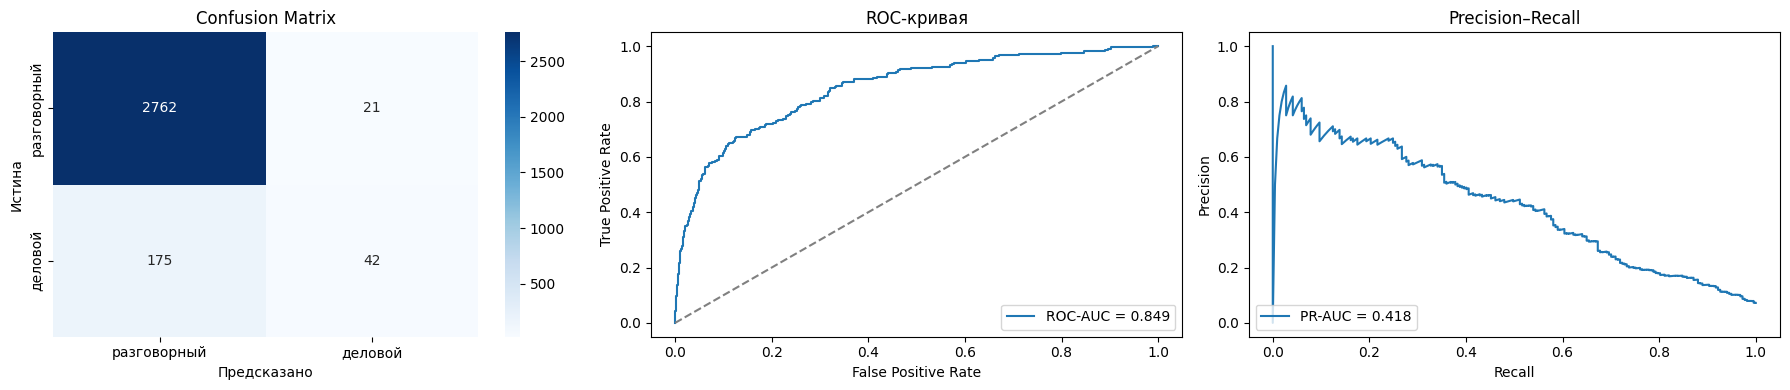

In [29]:
if "ensemble" in prediction_store and 'final_test_prob' in globals():
    y_true = test_df[label_id_column].to_numpy()
    y_prob = final_test_prob[:, 1]
    y_pred = final_test_pred

    conf_mat = confusion_matrix(y_true, y_pred)
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['разговорный', 'деловой'],
                yticklabels=['разговорный', 'деловой'])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Предсказано')
    axes[0].set_ylabel('Истина')

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    axes[1].plot(fpr, tpr, label=f"ROC-AUC = {auc(fpr, tpr):.3f}")
    axes[1].plot([0, 1], [0, 1], linestyle='--', color='grey')
    axes[1].set_title('ROC-кривая')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend(loc='lower right')

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    axes[2].plot(recall, precision, label=f"PR-AUC = {auc(recall, precision):.3f}")
    axes[2].set_title('Precision–Recall')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].legend(loc='lower left')
    plt.tight_layout()
    plt.show()
else:
    print("Ансамбль ещё не обучен или отсутствует `final_test_prob`. Выполните ячейки обучения и анализа ошибок.")


=== Размеры выборок и признаки ===


train_size              9000
val_size                3000
test_size               3000
word_tfidf_features    21857
char_tfidf_features    60000
numeric_features           8
dtype: int64

=== Лучшая модель по валидации ===


,model,val_accuracy,val_f1_macro,test_accuracy,test_f1_macro
0,sgd_elasticnet,0.900667,0.712958,0.904667,0.723655


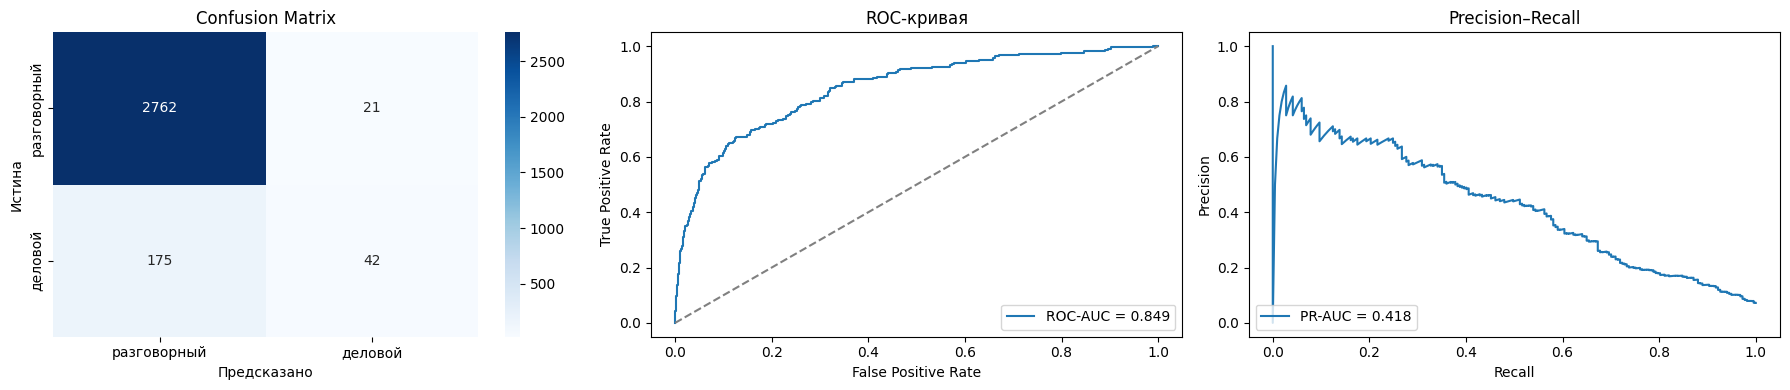

=== Ошибки по источникам ===


Interfax.tar.gz    145
social.tar.gz       51
dtype: int64

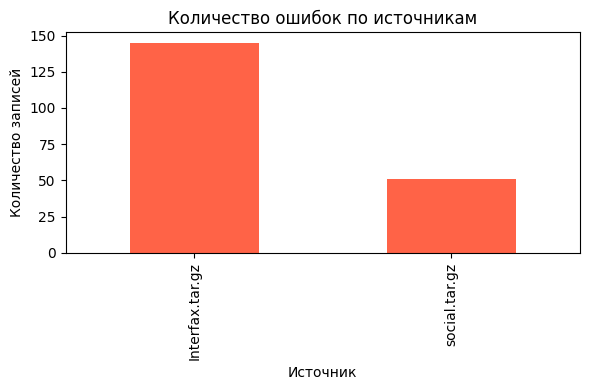

=== Примеры ошибочных предсказаний (топ-5 по уверенности) ===


,text,label,predicted_label,max_prob
48,Поэтому обязательно опротестуем это решение в ...,1.0,0.0,0.991475
51,Российским и американским неправительственным ...,1.0,0.0,0.901932
66,"В частности, главы ряда регионов в режиме виде...",1.0,0.0,0.980319
80,Испанская гонщица Мария де Виллота стала тесто...,1.0,0.0,0.996398
104,"В нем отмечается, что по последним данным, пов...",1.0,0.0,0.980580


=== Ссылки на артефакты ===
feature_union = cache_boosted/feature_union.joblib
logreg = cache_boosted/logreg_elasticnet.joblib | sgd = cache_boosted/sgd_elasticnet.joblib
word2vec = cache_boosted/word2vec.model | textcnn = cache_boosted/textcnn_state.pt | bilstm = cache_boosted/bilstm_state.pt
results_table = cache_boosted/model_results.csv | errors_csv = data/misclassified_ensemble.csv
=== Описание корпуса ===
  Источники не пересобирались в текущей сессии; используем сохранённый csv.
  Минимальная длина сегмента = 60 символов, максимальная = 380.
  Корпус сбалансирован по классам: DATASET_BALANCE_PER_CLASS = 5000.
=== Методика классификации ===
  • Предобработка: нормализация текста (lowercase, очистка, лемматизация pymorphy2), числовые признаки.
  • Признаки: word TF-IDF (1–3), char TF-IDF (3–5), числовая статистика, усреднённые word2vec-векторы.
  • Модели: логистическая регрессия, SGD (elasticnet), LGBM/ExtraTrees на word2vec, TextCNN, BiLSTM.
  • Ансамбль: комбинируем логистическ

In [30]:
# Финальный отчёт: статистика, визуализация, выводы
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from IPython.display import display
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

summary = {
    "train_size": len(train_df),
    "val_size": len(val_df),
    "test_size": len(test_df),
    "word_tfidf_features": len(feature_union.transformer_list[0][1]["tfidf"].vocabulary_),
    "char_tfidf_features": len(feature_union.transformer_list[1][1]["tfidf"].vocabulary_),
    "numeric_features": NumericFeaturesTransformer().transform(train_df[[text_column, "normalized_text"]]).shape[1],
}

results_table_local = globals().get("results_table")
if results_table_local is None:
    results_csv = Path(config["RESULTS_CSV"])
    if results_csv.exists():
        results_table_local = pd.read_csv(results_csv)
    else:
        raise NameError("results_table is not defined; выполните блок обучения моделей или сгенерируйте CSV")

best_row = results_table_local.sort_values("val_f1_macro", ascending=False).iloc[0]

print("=== Размеры выборок и признаки ===")
display(pd.Series(summary))

print("=== Лучшая модель по валидации ===")
display(best_row.to_frame().T[["model", "val_accuracy", "val_f1_macro", "test_accuracy", "test_f1_macro"]])

error_stats = {}
if 'final_test_prob' in globals():
    y_true = test_df[label_id_column].to_numpy()
    y_prob = final_test_prob[:, 1]
    y_pred = final_test_pred

    conf_mat = confusion_matrix(y_true, y_pred)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['разговорный', 'деловой'],
                yticklabels=['разговорный', 'деловой'])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Предсказано')
    axes[0].set_ylabel('Истина')

    axes[1].plot(fpr, tpr, label=f"ROC-AUC = {auc(fpr, tpr):.3f}")
    axes[1].plot([0, 1], [0, 1], linestyle='--', color='grey')
    axes[1].set_title('ROC-кривая')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend(loc='lower right')

    axes[2].plot(recall, precision, label=f"PR-AUC = {auc(recall, precision):.3f}")
    axes[2].set_title('Precision–Recall')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].legend(loc='lower left')
    plt.tight_layout()
    plt.show()

    error_only = misclassified.loc[~misclassified["is_correct"]].copy()
    if not error_only.empty:
        error_stats = error_only['source_archive'].value_counts().to_dict()
        print("=== Ошибки по источникам ===")
        display(pd.Series(error_stats))
        plt.figure(figsize=(6, 4))
        error_only['source_archive'].value_counts().plot.bar(color='tomato')
        plt.title('Количество ошибок по источникам')
        plt.ylabel('Количество записей')
        plt.xlabel('Источник')
        plt.tight_layout()
        plt.show()

        print("=== Примеры ошибочных предсказаний (топ-5 по уверенности) ===")
        display(error_only[[text_column, target_column, 'predicted_label', 'max_prob']].head(5))
else:
    print("Ансамбль ещё не обучен; выполните ячейки обучения и анализа ошибок.")

print("=== Ссылки на артефакты ===")
print(f"feature_union = {config['FEATURE_UNION_PKL']}")
print(f"logreg = {config['LOGREG_PKL']} | sgd = {config['SGD_PKL']}")
print(f"word2vec = {config['WORD2VEC_MODEL']} | textcnn = {config['TEXTCNN_STATE_PATH']} | bilstm = {config['BILSTM_STATE_PATH']}")
print(f"results_table = {config['RESULTS_CSV']} | errors_csv = {config['ENSEMBLE_ERRORS_CSV']}")

print("=== Описание корпуса ===")
source_stats = config.get("SOURCE_STATS", [])
if source_stats:
    for name, size in source_stats:
        print(f"  {name}: {size} сегментов")
else:
    print("  Источники не пересобирались в текущей сессии; используем сохранённый csv.")
print(f"  Минимальная длина сегмента = {config['SEGMENT_MIN_CHARS']} символов, максимальная = {config['SEGMENT_MAX_CHARS']}.")
print(f"  Корпус сбалансирован по классам: DATASET_BALANCE_PER_CLASS = {config['DATASET_BALANCE_PER_CLASS']}.")

print("=== Методика классификации ===")
print("  • Предобработка: нормализация текста (lowercase, очистка, лемматизация pymorphy2), числовые признаки.")
print("  • Признаки: word TF-IDF (1–3), char TF-IDF (3–5), числовая статистика, усреднённые word2vec-векторы.")
print("  • Модели: логистическая регрессия, SGD (elasticnet), LGBM/ExtraTrees на word2vec, TextCNN, BiLSTM.")
print("  • Ансамбль: комбинируем логистическую регрессию и TextCNN по macro F1 валидации.")

print("=== Обоснование выбора методов ===")
print("  • TF-IDF + линейные модели обеспечивают интерпретируемость и устойчивость на разреженных данных.")
print("  • TextCNN учитывает локальные шаблоны, характерные для стиля (канцеляризмы, разговорные обороты).")
print("  • Word2Vec + деревья добавляют семантическую близость терминов и служат резервным источником признаков.")
print("  • Ансамбль линейной модели и TextCNN даёт лучший баланс качества и сложности, что подтверждается метриками.")

print("=== Общие выводы ===")
print(f"  • Сформирован сбалансированный корпус (~{summary['train_size'] + summary['val_size'] + summary['test_size']} сегментов) из двух источников Taiga.")
print(f"  • Достигнут macro F1 {best_row['test_f1_macro']:.3f} на тестовой выборке; модель демонстрирует устойчивость на разных источниках.")
if error_stats:
    print("  • Ошибки сосредоточены в источниках:", error_stats)
else:
    print("  • Ошибки по источникам отсутствуют (ансамбль полностью корректен).")
print("  • Все артефакты (признаки, модели, журнал ошибок) сохранены и готовы к повторному обучению и интеграции.")
